<a href="https://colab.research.google.com/github/kkadadas/CNNC/blob/main/car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
!git clone https://github.com/kkadadas/CNNC.git

fatal: destination path 'CNNC' already exists and is not an empty directory.


In [94]:
!ls CNNC

driving_log.csv  IMG  LICENSE  README.md


In [95]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [96]:
## Store data
datadir = 'CNNC'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


,center,left,right,steering,throttle,reverse,speed
0,E:\Self Driving Car\images\IMG\IMG\center_2021_05_11_16_07_01_674.jpg,E:\Self Driving Car\images\IMG\IMG\left_2021_05_11_16_07_01_674.jpg,E:\Self Driving Car\images\IMG\IMG\right_2021_05_11_16_07_01_674.jpg,0.0,0.0,0.0,8.051432e-06
1,E:\Self Driving Car\images\IMG\IMG\center_2021_05_11_16_07_01_741.jpg,E:\Self Driving Car\images\IMG\IMG\left_2021_05_11_16_07_01_741.jpg,E:\Self Driving Car\images\IMG\IMG\right_2021_05_11_16_07_01_741.jpg,0.0,0.0,0.0,1.311398e-05
2,E:\Self Driving Car\images\IMG\IMG\center_2021_05_11_16_07_01_810.jpg,E:\Self Driving Car\images\IMG\IMG\left_2021_05_11_16_07_01_810.jpg,E:\Self Driving Car\images\IMG\IMG\right_2021_05_11_16_07_01_810.jpg,0.0,0.0,0.0,5.129482e-06
3,E:\Self Driving Car\images\IMG\IMG\center_2021_05_11_16_07_01_885.jpg,E:\Self Driving Car\images\IMG\IMG\left_2021_05_11_16_07_01_885.jpg,E:\Self Driving Car\images\IMG\IMG\right_2021_05_11_16_07_01_885.jpg,0.0,0.0,0.0,9.946230e-06
4,E:\Self Driving Car\images\IMG\IMG\center_2021_05_11_16_07_01_952.jpg,E:\Self Driving Car\images\IMG\IMG\left_2021_05_11_16_07_01_952.jpg,E:\Self Driving Car\images\IMG\IMG\right_2021_05_11_16_07_01_952.jpg,0.0,0.0,0.0,7.863048e-07


In [97]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

## Remove path of images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_05_11_16_07_01_674.jpg,left_2021_05_11_16_07_01_674.jpg,right_2021_05_11_16_07_01_674.jpg,0.0,0.0,0.0,8.051432e-06
1,center_2021_05_11_16_07_01_741.jpg,left_2021_05_11_16_07_01_741.jpg,right_2021_05_11_16_07_01_741.jpg,0.0,0.0,0.0,1.311398e-05
2,center_2021_05_11_16_07_01_810.jpg,left_2021_05_11_16_07_01_810.jpg,right_2021_05_11_16_07_01_810.jpg,0.0,0.0,0.0,5.129482e-06
3,center_2021_05_11_16_07_01_885.jpg,left_2021_05_11_16_07_01_885.jpg,right_2021_05_11_16_07_01_885.jpg,0.0,0.0,0.0,9.946230e-06
4,center_2021_05_11_16_07_01_952.jpg,left_2021_05_11_16_07_01_952.jpg,right_2021_05_11_16_07_01_952.jpg,0.0,0.0,0.0,7.863048e-07


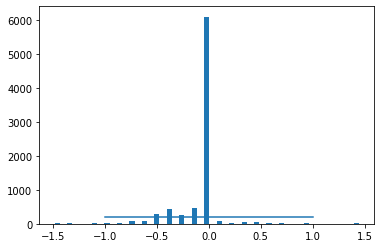

In [98]:
## Visualize data
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

## Plot
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total data: 8064
Removed: 6537
Remaining: 1527


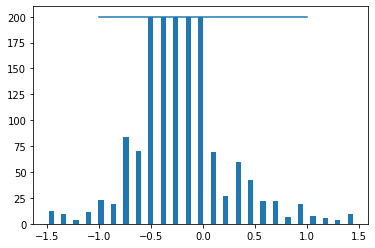

In [99]:
print('Total data: {0}'.format(len(data)))

## Make list of indices to remove
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    steering_angle = data['steering'][i]
    if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
## Remove from extras from list
data.drop(data.index[remove_list], inplace=True)
print('Removed: {0}'.format(len(remove_list)))
print('Remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [100]:
def load_img_steering(datadir, df):
  """Get img and steering data into arrays"""
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

Training Samples: 1221
Valid Samples: 306


Text(0.5, 1.0, 'Validation set')

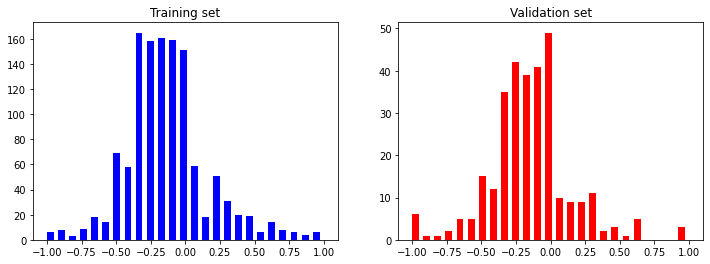

In [101]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

## Check that data is valid
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [102]:
def img_preprocess(img):
  """Take in path of img, returns preprocessed image"""
  img = npimg.imread(img)
  
  ## Crop image to remove unnecessary features
  img = img[60:135, :, :]
  
  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)
  
  ## Decrease size for easier processing
  img = cv2.resize(img, (100, 100))
  
  ## Normalize values
  img = img / 255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

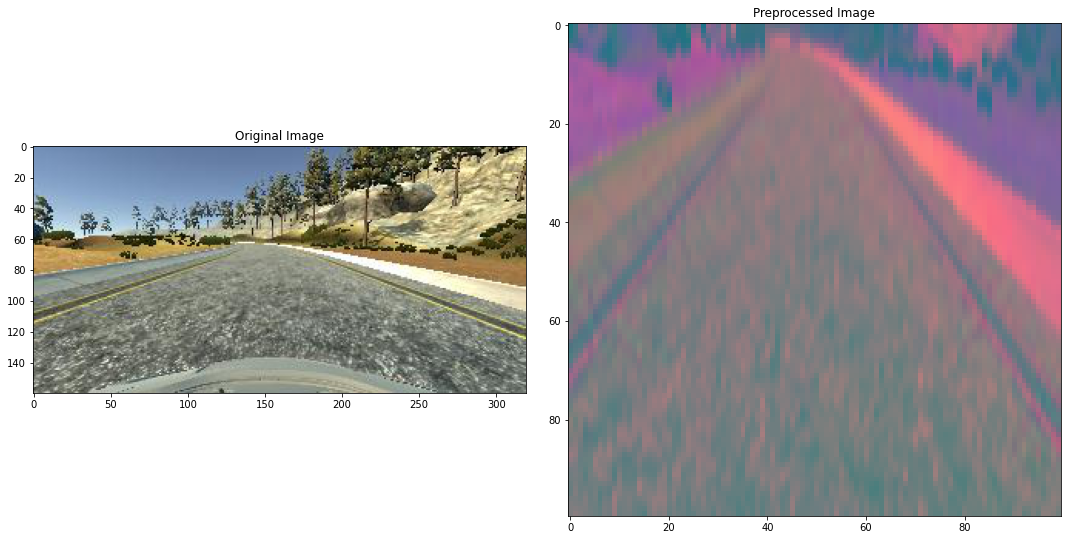

In [103]:
## Get any image
image = image_paths[100]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

## Compare original and preprocessed image
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [104]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1221, 100, 100, 3)


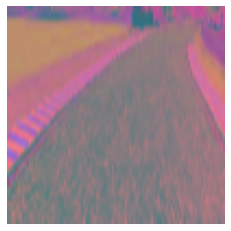

In [105]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [106]:
from keras.applications.resnet50 import ResNet50
#Load the ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [107]:
# Freeze the layers except the last 4 layers
for layer in resnet.layers[:-4]:
    layer.trainable = False
 
for layer in resnet.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fac0eac0590> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fab360952d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fab36100990> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fab360a91d0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fab3611fb10> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fac0eaeb390> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fab3613b950> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fab360c1450> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fab360b1cd0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fab360576d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fab360c1790> False
<tensorflow.python.keras.laye

In [108]:
def nvidia_model():
  model = Sequential()
  model.add(resnet)

  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

In [109]:
model = nvidia_model()
model.build((None, 100, 100, 3))
print(model.summary())

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_8 (ModuleWrap (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dropout_32 (Dropout)         (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               3276900   
_________________________________________________________________
dropout_33 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_34 (Dropout)         (None, 50)               

In [110]:
history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_valid, Y_valid), batch_size=1024, verbose=1, shuffle=1)


Epoch 1/25
2/2 [==============================] - 6s 2s/step - loss: 21.7268 - accuracy: 0.0851 - val_loss: 1.4272 - val_accuracy: 0.0098
Epoch 2/25
2/2 [==============================] - 1s 244ms/step - loss: 32.0702 - accuracy: 0.0728 - val_loss: 1.8302 - val_accuracy: 0.0098
Epoch 3/25
2/2 [==============================] - 1s 241ms/step - loss: 11.1343 - accuracy: 0.0571 - val_loss: 1.9175 - val_accuracy: 0.0098
Epoch 4/25
2/2 [==============================] - 1s 245ms/step - loss: 7.4934 - accuracy: 0.0521 - val_loss: 1.9031 - val_accuracy: 0.0098
Epoch 5/25
2/2 [==============================] - 1s 237ms/step - loss: 5.1699 - accuracy: 0.0513 - val_loss: 1.5194 - val_accuracy: 0.0098
Epoch 6/25
2/2 [==============================] - 1s 240ms/step - loss: 5.1147 - accuracy: 0.0600 - val_loss: 1.1978 - val_accuracy: 0.0098
Epoch 7/25
2/2 [==============================] - 1s 247ms/step - loss: 2.9614 - accuracy: 0.0725 - val_loss: 0.3725 - val_accuracy: 0.1601
Epoch 8/25
2/2 [====

Text(0.5, 0, 'Epoch')

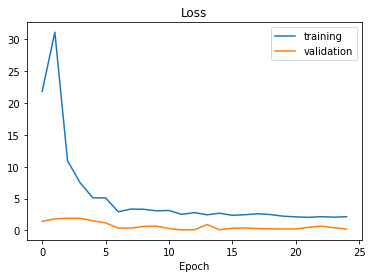

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')